# Penguin Sex Classifier

# Imports

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, make_scorer, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, GridSearchCV, train_test_split

# Functions

In [124]:
def check_ful_nulls_dupes(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of Duplicates: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def plot_model_performance(metric_tracker, axis, figsize, sort_val, ascending):
  df = pd.DataFrame(metric_tracker).sort_values(by=sort_val, ascending=ascending).reset_index()
  print(df)
  y = [col for col in df.columns if col !="Model" and col !="index"]
  
  fig, ax = plt.subplots(figsize=(figsize))
  df.plot.bar(x="Model", y=y, ax=ax)
  ax.set_title("Model Performance")
  ax.set_ylabel(axis)
  ax.set_xlabel("Models")
  ax.grid(True)
  plt.xticks(rotation=45)
  plt.show()

def plot_confusion_matrix(y_test, y_pred, model_name):
  
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For Model: {model_name}")
  plt.xlabel("True Labels")
  plt.ylabel("Predicted Labels")
  plt.show()

def create_preprocessor(numeric_features_mean, numeric_features_median, categorical_features):
  numeric_features_mean_cols = numeric_features_mean.columns
  numeric_features_median_cols = numeric_features_median.columns
  categorical_features_cols = categorical_features.columns
  
  numeric_transformer_mean = Pipeline(
    steps=[
      ("imputer", SimpleImputer(strategy="mean")),
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  numeric_transformer_median = Pipeline(
    steps=[
      ("imputer", SimpleImputer(strategy="median")),
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  categorical_transformer = Pipeline(
    steps=[
      ("imputer", SimpleImputer(strategy="most_frequent")),
      ("encode", OneHotEncoder())
    ]
  )
  
  return ColumnTransformer(transformers=[
    ("numeric_mean", numeric_transformer_mean, numeric_features_mean_cols),
    ("numeric_median", numeric_transformer_median, numeric_features_median_cols),
    ("cat", categorical_transformer, categorical_features_cols)
  ])
def create_sklearn_pipeline(preprocessor, model):
  
  return Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
  ])

def grab_selected_models(model_names):
  models = {
    "LR": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVC": SVC(),
    "KNN":KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
    "XGB": XGBClassifier(),
    "Dummy": DummyClassifier(strategy="uniform")
  }
  return [models[model] for model in model_names]

def evaluate_model(model, X, y, scoring_metric):
  cv = RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=42)
  scores = cross_val_score(model, X, y, scoring=scoring_metric, cv=cv, n_jobs=-1)
  predictions = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  
  acc = accuracy_score(y, predictions)
  f1_metric = f1_score(y, predictions)
  recall_metric = recall_score(y, predictions)
  precision_metric = precision_score(y, predictions)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(f1_metric, 3), 
    round(recall_metric,3),
    round(precision_metric,3),
  ]

def test_selected_models(preprocessor, models, model_names, X, y, scoring_metric):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline(preprocessor, model)
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "F1-Score":scores[4],
      "recall-Score":scores[5],
      "precision-Score":scores[6]
    })
  
  plot_model_performance(metric_tracker, "Metrics", (15, 8), "Mean", False)

def grid_search(preprocessor, models, model_names, scoring_metric, params, X, y):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline(preprocessor, model)
    
    grid_search = GridSearchCV(pipeline, param_grid=params[model_name], scoring=scoring_metric, cv=10, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    y_pred = best_model.predict(X_test)
    
    acc_score = accuracy_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred)
    precision_metric = precision_score(y_test, y_pred)
    recall_metric = recall_score(y_test, y_pred)
    
    plot_confusion_matrix(y_test, y_pred, model_name)
    print(f"The Best Param: {best_params}\n The Best Score: {best_score}")
    metric_tracker.append({
      "Model": model_name,
      "Test-Acc":acc_score,
      "F1-Score":f1_metric,
      "recall-Score":recall_metric,
      "precision-Score":precision_metric
    })
    
    plot_model_performance(metric_tracker, "Metric", (15, 8), "Test-Acc", False)
    

# EDA Analysis

In [89]:
df = pd.read_csv("/Users/maukanmir/Downloads/Penguins.csv")
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


# Check for Nulls and Dupes

In [90]:
check_ful_nulls_dupes(df)

The amount of Nulls: species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64
The amount of Duplicates: 0


# We have some null values in our dataset in which we will have to figure out how to handle, if we fill them in with values, we will have to be aware of how we might be injecting bias into the dataset.

# Null Values

In [91]:
df[df.isnull().any(axis=1)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


<AxesSubplot:xlabel='species', ylabel='counts'>

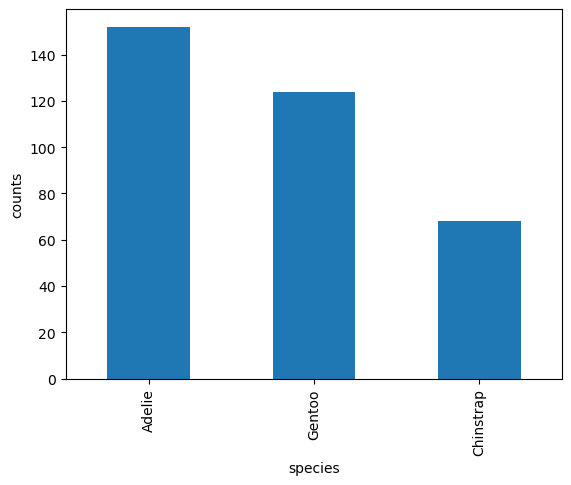

In [92]:
df["species"].value_counts().plot.bar(xlabel="species", ylabel="counts")

<AxesSubplot:xlabel='island', ylabel='counts'>

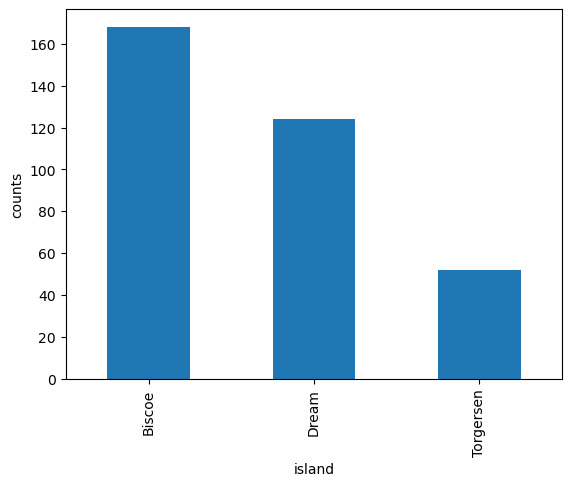

In [93]:
df["island"].value_counts().plot.bar(xlabel="island", ylabel="counts")

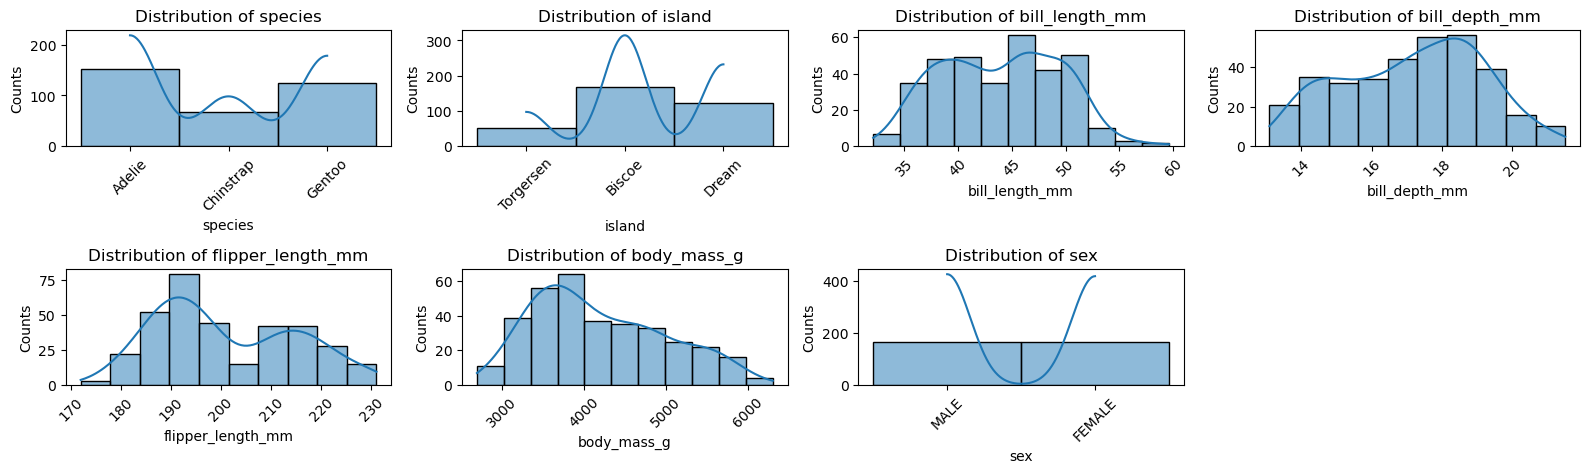

In [94]:
plt.figure(figsize=(16, 16))
rows = len(df.columns)
dims = (rows +3)//4

for idx, col in enumerate(df.columns):
  plt.subplot(rows,4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.xlabel(col)
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

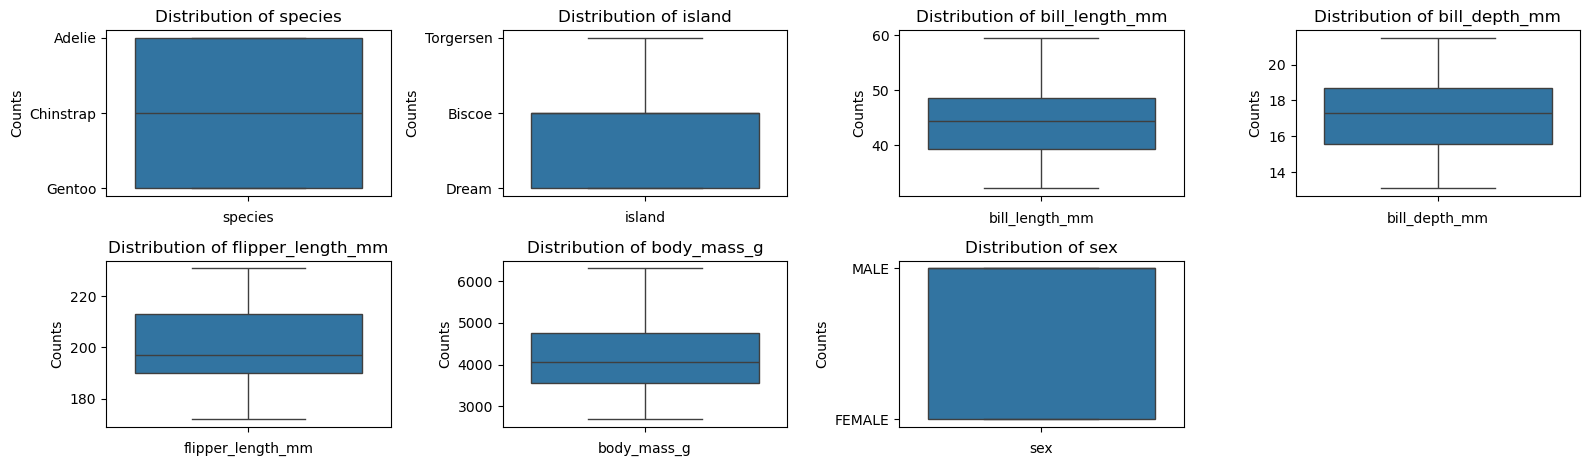

In [95]:
plt.figure(figsize=(16, 16))
rows = len(df.columns)
dims = (rows +3)//4

for idx, col in enumerate(df.columns):
  plt.subplot(rows,4, idx+1)
  sns.boxplot(df[col])
  plt.title(f"Distribution of {col}")
  plt.xlabel(col)
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [96]:
df.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

In [97]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [98]:
numeric_features, categorical_features = df.select_dtypes(include="float64"), df.select_dtypes(include="object").drop("sex", axis=1)

In [99]:
for col in numeric_features.columns:
  print(f"Col is {col}, skew: {df[col].skew()}")

Col is bill_length_mm, skew: 0.05311806699132413
Col is bill_depth_mm, skew: -0.1434646251943698
Col is flipper_length_mm, skew: 0.34568183286876963
Col is body_mass_g, skew: 0.470329330480123


# Since the skew is very marginal, we can use the mean as a method to impute these missing values for bill length variables and the median for more skewed variables such body mass and flipper length

In [100]:
numeric_features_mean = numeric_features[['bill_length_mm', 'bill_depth_mm']]
numeric_features_median = numeric_features[['flipper_length_mm', 'body_mass_g']]

# Create Preprocessor

In [101]:
preprocessor = create_preprocessor(numeric_features_mean, numeric_features_median, categorical_features)

In [102]:
preprocessor

ColumnTransformer(transformers=[('numeric_mean',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['bill_length_mm', 'bill_depth_mm'], dtype='object')),
                                ('numeric_median',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['flipper_length_mm', 'body_mass_g'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode', OneHotEncoder())]),
                                 Index(['species', 'island'], dtype='object'))])

# Beauitful Our Processor Is Created

# Now since I have 11 values from my target variable missing, instead of dropping those rows, what I want to do is try and predict those values for our model. Let's have some fun

In [103]:
train_data, predict_data = df[df["sex"].notna()], df[df["sex"].isna()]

X_train = train_data.drop("sex", axis=1)
y_train = train_data["sex"]

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

pipeline = create_sklearn_pipeline(preprocessor, XGBClassifier())

pipeline.fit(X_train, y_train_encoded)

X_to_predict = predict_data.drop("sex", axis=1)

predicted_targets = pipeline.predict(X_to_predict)

predicted_labels = encoder.inverse_transform(predicted_targets)

df.loc[df["sex"].isna(), "sex"] = predicted_labels

# Now we can see our class balance for out target variable.

# Check for class Imbalance

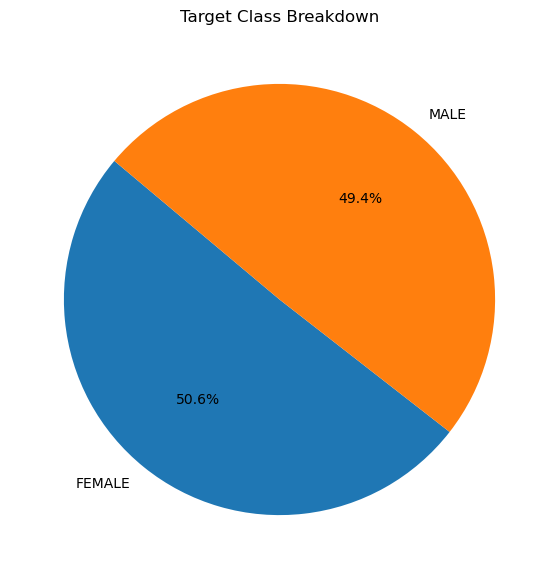

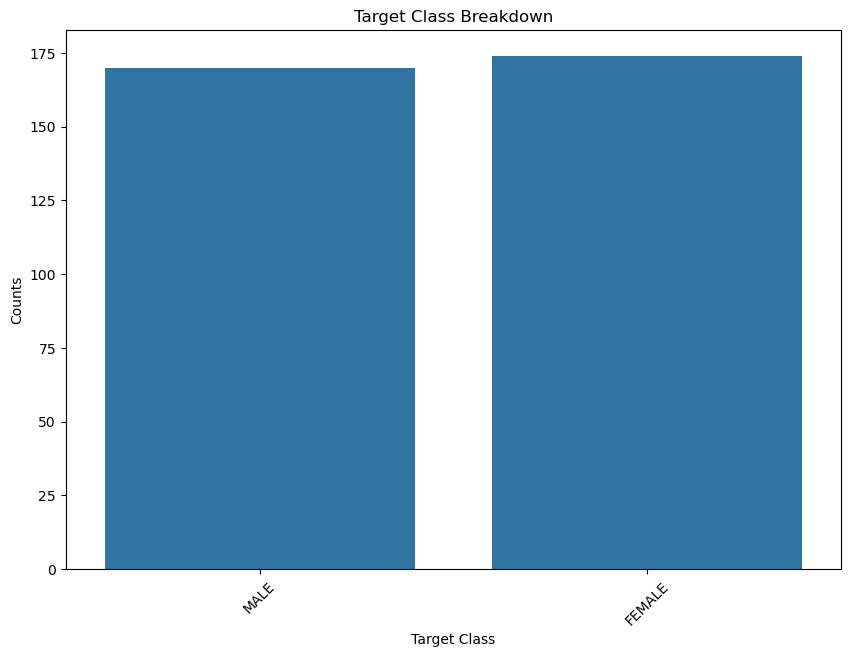

In [105]:
check_class_imbalance(df["sex"])

# Heat Maps

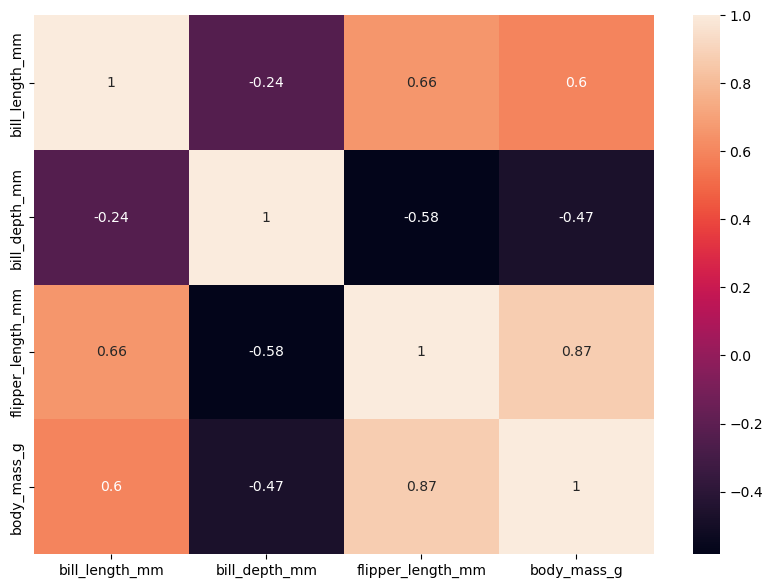

In [106]:
plt.figure(figsize=(10, 7))
sns.heatmap(data=numeric_features.corr(), annot=True)
plt.show()

# Metrics to test, since we have a balanced dataset, accuracy score is a good metric to use but we will test for f1 metric and others just out of curiosity.

In [110]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True)
precision_metric = make_scorer(precision_score, greater_is_better=True)
recall_metric = make_scorer(recall_score, greater_is_better=True)

# Separate Feature Variables

In [112]:
X, y = df.drop("sex", axis=1), df["sex"]

# Encode Categorical Column

In [113]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)

# Baseline Model Performance

   index  Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0      0  Dummy  0.509  0.007  0.082     0.535     0.543         0.559   

   precision-Score  
0            0.528  


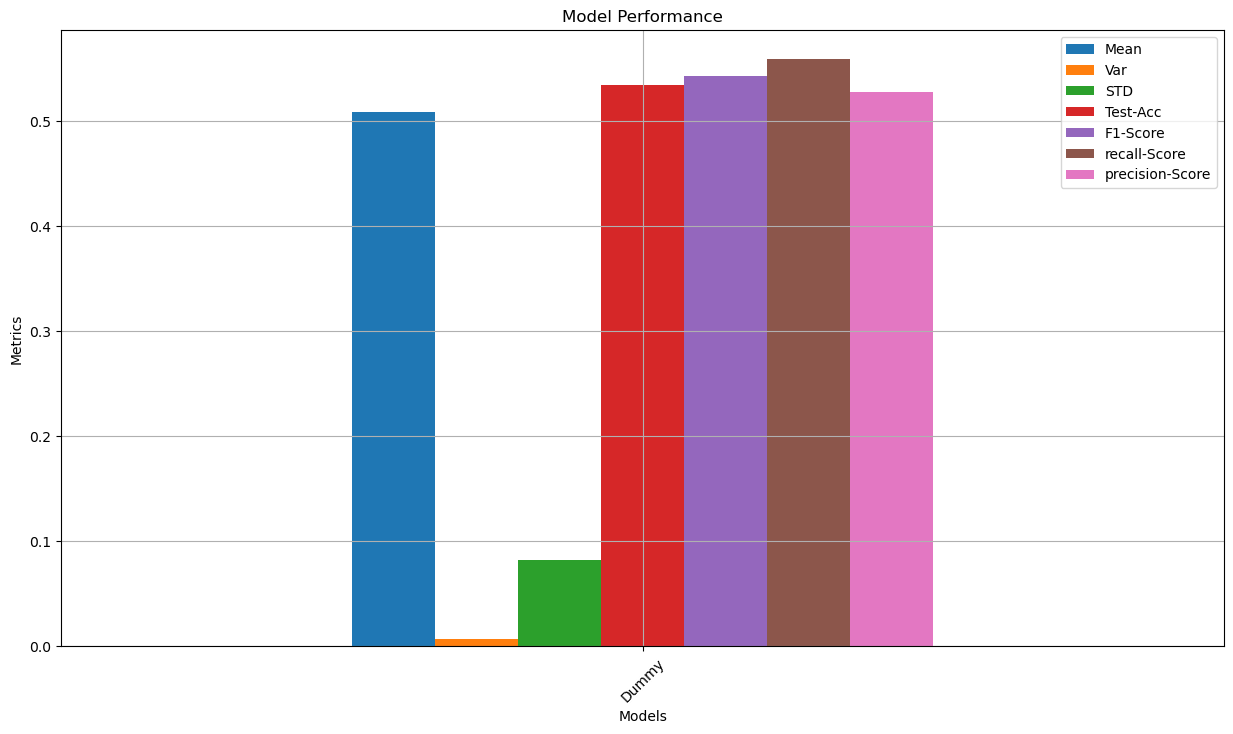

In [115]:
model_names = ["Dummy"]
model = grab_selected_models(model_names)
test_selected_models(preprocessor, model, model_names, X, y_encoded, acc_metric)

# Our Dummy Model predicts 50% accuracy which makes sense given that our target class is evenly balanced.

# F1 Metric Testing

   index  Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0      0  Dummy  0.497  0.006  0.079     0.462     0.416         0.388   

   precision-Score  
0            0.449  


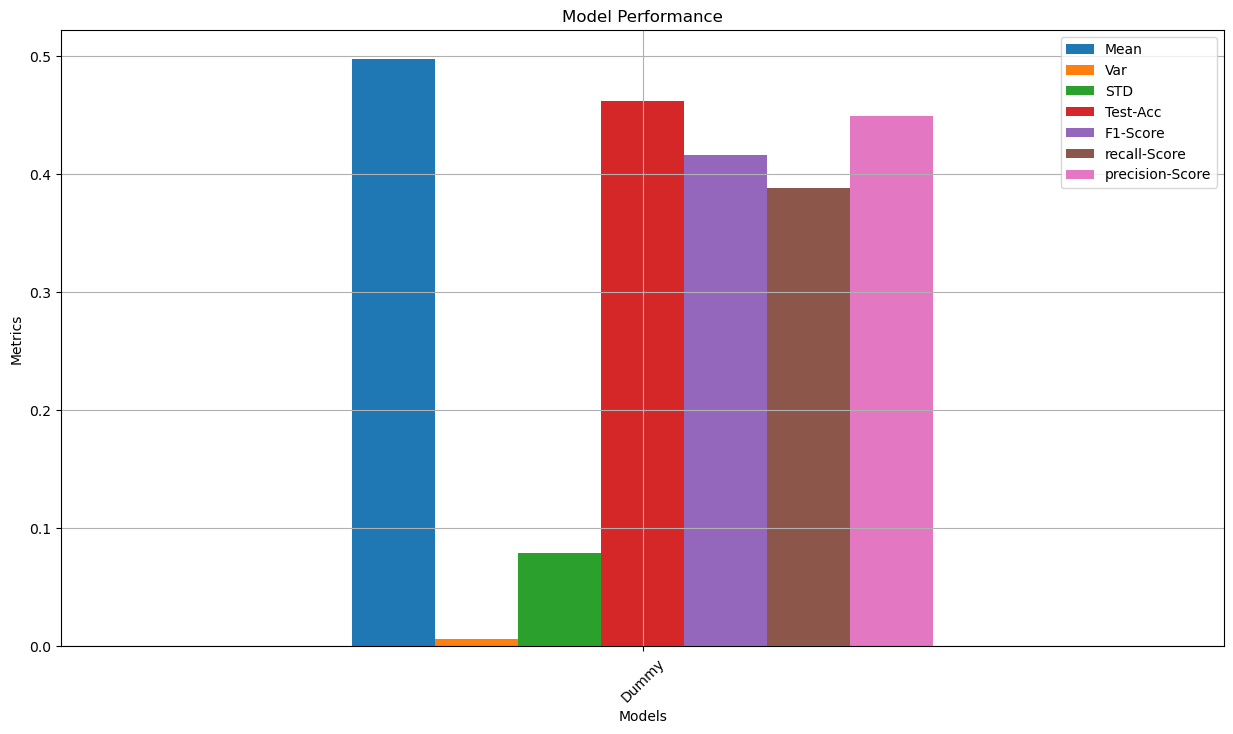

In [116]:
test_selected_models(preprocessor, model, model_names, X, y_encoded, f1_metric)

# Let's get to the fun stuff, let's test our models and see the results.

# Acc Metric Test

   index Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0      3   GBC  0.925  0.002  0.043     0.901     0.899         0.888   
1      1   RFC  0.921  0.002  0.047     0.904     0.903         0.906   
2      4    LR  0.914  0.002  0.049     0.901     0.899         0.894   
3      0   XGB  0.912  0.002  0.045     0.892     0.891         0.894   
4      5   SVC  0.907  0.003  0.050     0.892     0.893         0.906   
5      6   KNN  0.901  0.003  0.051     0.890     0.888         0.888   
6      2   DTC  0.873  0.003  0.057     0.846     0.841         0.824   

   precision-Score  
0            0.910  
1            0.901  
2            0.905  
3            0.889  
4            0.880  
5            0.888  
6            0.859  


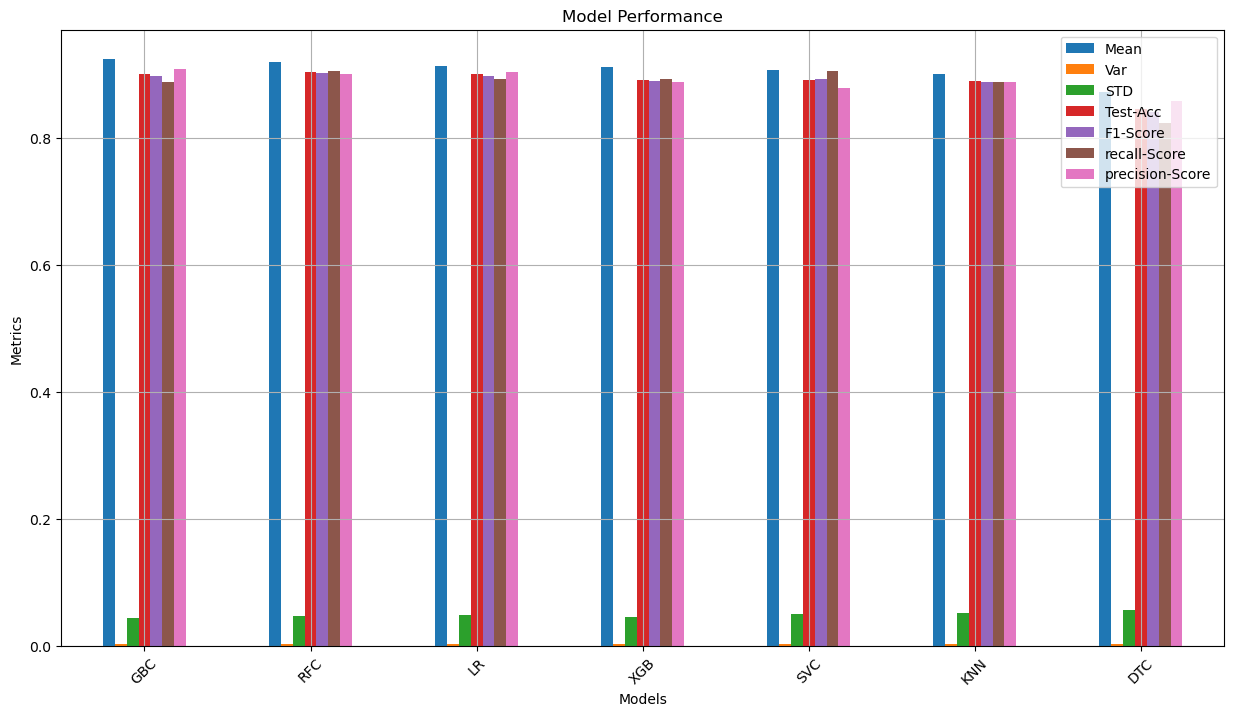

In [117]:
model_names = ["XGB", "RFC", "DTC", "GBC","LR", "SVC", "KNN"]
model = grab_selected_models(model_names)
test_selected_models(preprocessor, model, model_names, X, y_encoded, acc_metric)

   index Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0      3   GBC  0.924  0.002  0.045     0.901     0.899         0.888   
1      1   RFC  0.920  0.002  0.041     0.910     0.910         0.924   
2      4    LR  0.912  0.003  0.051     0.901     0.899         0.894   
3      0   XGB  0.911  0.002  0.047     0.892     0.891         0.894   
4      5   SVC  0.907  0.003  0.052     0.892     0.893         0.906   
5      6   KNN  0.900  0.003  0.053     0.890     0.888         0.888   
6      2   DTC  0.870  0.003  0.056     0.849     0.845         0.835   

   precision-Score  
0            0.910  
1            0.897  
2            0.905  
3            0.889  
4            0.880  
5            0.888  
6            0.855  


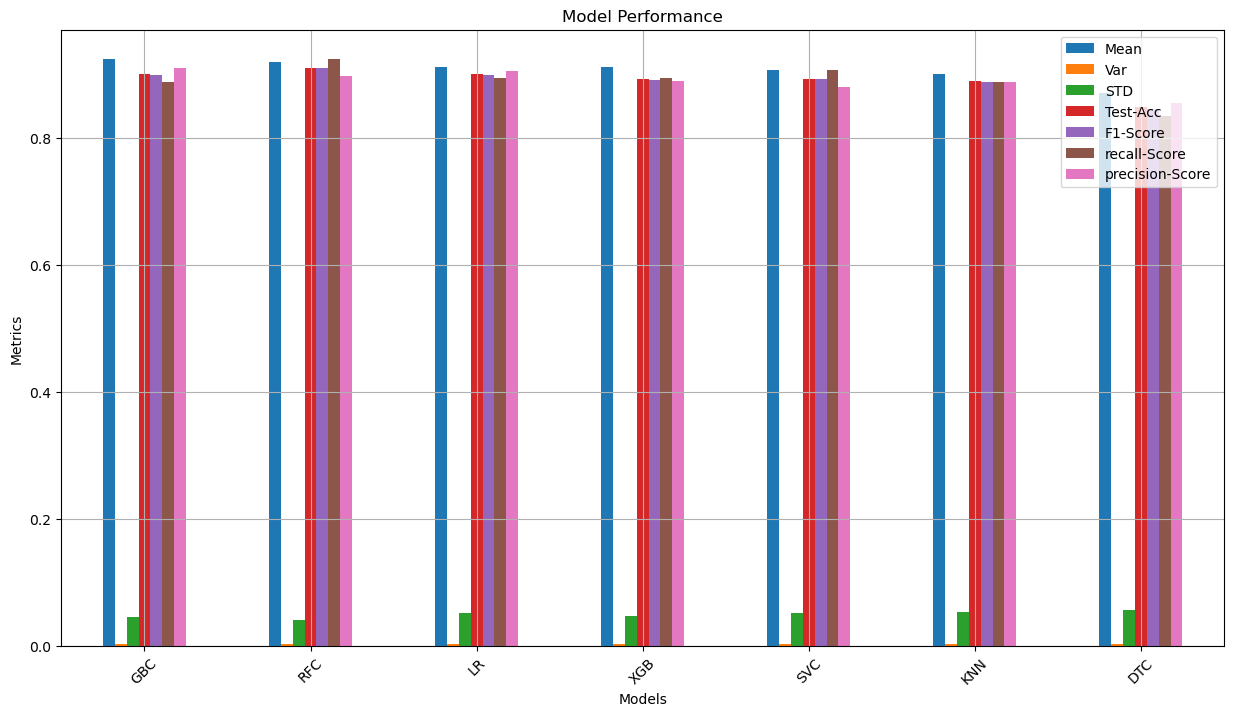

In [118]:
test_selected_models(preprocessor, model, model_names, X, y_encoded, f1_metric)

# Interesting results here, our model performs well for all metrics given that we have the luxury of a balanced class.

# Let's do a grid search and try to find the best model

In [126]:
params={
"RFC":{
    'model__n_estimators': [100, 200, 300],
    "model__criterion":['gini', 'entropy'],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
  },
  "XGB": {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 6, 9, 12],
    'model__min_child_weight': [1, 2, 4, 6],
    'model__gamma': [0, 0.1, 0.2, 0.3]
  },

  "SVC": {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__degree': [2, 3, 4],
    'model__gamma': ['scale', 'auto'],
    'model__coef0': [0.0, 0.5, 1.0]
  },
  
  "LR":{
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [100, 200, 300]
},
  
  "KNN":{
    'model__neighbors': [3, 5, 7, 10, 15],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__p': [1, 2]
  },
  
  "GBC":{
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 8],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
  }
}

model_names = ["RFC", "GBC", "XGB", "SVC", "LR", "KNN"]
models = grab_selected_models(model_names)

grid_search(preprocessor, models, model_names, acc_metric, params, X, y_encoded)